## Peter Chika Ozo-ogueji
## FIN-666 Homework-9


### These homework consists of two comprehensive machine learning tasks centered on predictive modeling. The first task focuses on building Support Vector Machine (SVM) classifiers to predict loan default probability using LendingClub's loan data. Students must clean the data, select relevant features, and split the dataset into training (75%) and testing (25%) portions. They need to develop two SVM models one using the original unbalanced dataset and another using a balanced dataset created by undersampling the majority class then compare their performance through confusion matrices, accuracy, precision, and recall metrics to analyze how sample balancing affects prediction outcomes. The second task requires students to predict individual income levels (above or below $50,000) using 1994 Census data by creating a binary "HighIncome" variable. After performing feature selection and using the same data splitting approach, students must build and evaluate three different models: a basic Decision Tree classifier and two ensemble methods (Random Forest and Gradient Boosting). The assignment concludes with a comparative analysis of these models' performance metrics and an explanation of why the ensemble methods might outperform the individual Decision Tree based on their underlying objectives and mechanisms.

In [3]:
# Basic packages:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML packages:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

In [5]:
# Task 1.a: SVM for Loan Default Prediction (Unbalanced Sample)

# Set random seed for reproducibility
np.random.seed(101)

Task 1: SVM for Loan Default Prediction


C:\Users\auuser\AppData\Local\Temp\ipykernel_18300\2675201674.py:8: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("HW9_LoansData.csv")


Loan status distribution:
Binary loan status distribution (proportion):
Shape after dropping columns with >30% missing values: (86138, 92)
Shape after keeping only relevant features: (86138, 16)
Features with low correlation (<0.10) to drop: ['annual_inc', 'avg_cur_bal', 'funded_amnt', 'installment', 'loan_amnt']
Final shape after correlation-based feature selection: (86138, 11)
Categorical columns to encode: ['earliest_cr_line', 'home_ownership', 'sub_grade']
Training set shape: (64603, 9), Test set shape: (21535, 9)

Task 1.a: SVM on unbalanced sample
SVM Unbalanced - Accuracy: 0.8131
Classification Report (unbalanced):
              precision    recall  f1-score   support

           0       0.81      1.00      0.90     17510
           1       0.00      0.00      0.00      4025

    accuracy                           0.81     21535
   macro avg       0.41      0.50      0.45     21535
weighted avg       0.66      0.81      0.73     21535



C:\Users\auuser\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\auuser\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\auuser\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 800x600 with 0 Axes>

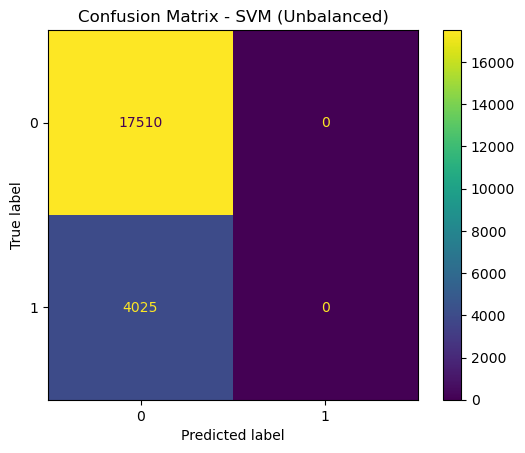

In [6]:
################################
# Task 1: SVM for Loan Default Prediction
################################

print("Task 1: SVM for Loan Default Prediction")

# Import the data
df = pd.read_csv("HW9_LoansData.csv")
df.shape

# Check out the distribution of loan_status
print("Loan status distribution:")
df['loan_status'].value_counts(dropna=False)

# Convert to binary classification (Fully Paid vs Charged Off)
df = df.loc[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]
print("Binary loan status distribution (proportion):")
df['loan_status'].value_counts(normalize=True)

# Encode the output variable
df['charged_off'] = df['loan_status'].map(lambda x: 1 if 'Charged Off' in x else 0)
df.drop('loan_status', axis=1, inplace=True)

# Feature selection
# 1) Eliminating variables with many missing values
missing_frac = df.isnull().mean().sort_values(ascending=False)
drop_list = sorted(list(missing_frac[missing_frac > 0.3].index))
df.drop(labels=drop_list, axis=1, inplace=True)
print(f"Shape after dropping columns with >30% missing values: {df.shape}")

# 2) Eliminating variables based on intuition (keeping only most relevant)
keep_list = ['charged_off', 'funded_amnt', 'annual_inc', 'dti', 'earliest_cr_line', 
            'fico_range_high', 'home_ownership', 'installment', 'int_rate', 'term', 
            'loan_amnt', 'grade', 'sub_grade', 'last_pymnt_amnt', 'avg_cur_bal', 'acc_open_past_24mths']
df = df[keep_list]
print(f"Shape after keeping only relevant features: {df.shape}")

# 3) Eliminating features based on correlations with the output variable
num_df = df.select_dtypes(include=[np.number])
corr = num_df.corr()
corr_chargedoff = abs(corr['charged_off'])
drop_list_corr = sorted(list(corr_chargedoff[corr_chargedoff < 0.10].index))
print(f"Features with low correlation (<0.10) to drop: {drop_list_corr}")
df.drop(labels=drop_list_corr, axis=1, inplace=True)
print(f"Final shape after correlation-based feature selection: {df.shape}")

# Feature exploration and further preprocessing
# 1) Loan Term - convert to integers
df['term'] = df['term'].map(lambda x: int(x.split()[0]))

# 2) Loan Grade - analyze charge-off rates by grade
# Since sub_grade is more granular, we'll drop grade and keep sub_grade
df.drop(['grade'], axis=1, inplace=True)

# Encode categorical data
cat_mask = df.dtypes == object
cat_cols = df.columns[cat_mask].tolist()
print(f"Categorical columns to encode: {cat_cols}")

# Apply LabelEncoder to categorical features
for col in cat_cols:
    new_col = f"{col}_code"
    df[new_col] = LabelEncoder().fit_transform(df[col])
df.drop(cat_cols, axis=1, inplace=True)

# Sample split for unbalanced data (Task 1.a)
y = df['charged_off']
X = df.drop('charged_off', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")

# Task 1.a: SVM on unbalanced sample
print("\nTask 1.a: SVM on unbalanced sample")
svm_unbalanced = SVC(kernel='rbf', random_state=101)
svm_unbalanced.fit(X_train, y_train)

# Predictions and evaluation
y_pred_unbalanced = svm_unbalanced.predict(X_test)
accuracy_unbalanced = accuracy_score(y_test, y_pred_unbalanced)
print(f"SVM Unbalanced - Accuracy: {accuracy_unbalanced:.4f}")
print("Classification Report (unbalanced):")
print(classification_report(y_test, y_pred_unbalanced))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(svm_unbalanced, X_test, y_test)
plt.title('Confusion Matrix - SVM (Unbalanced)')
plt.savefig('svm_unbalanced_confusion.png')
plt.show()

In [7]:
################################
# Task 1.b: SVM on Balanced Sample
################################

Task 1.b: Creating a balanced sample by under-sampling the majority class
Balanced dataset shape: (32312, 10)
Balanced class distribution:
Training SVM on balanced sample:
SVM Balanced Accuracy Score = 0.7850
SVM Balanced Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.58      0.73      4084
           1       0.70      0.99      0.82      3994

    accuracy                           0.78      8078
   macro avg       0.84      0.79      0.78      8078
weighted avg       0.85      0.78      0.78      8078



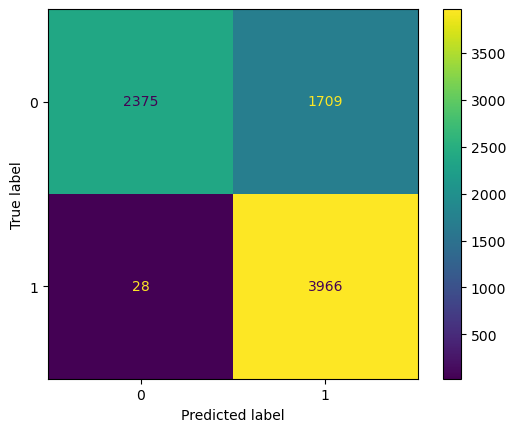

In [8]:
# Under-sampling data to get balanced classes
print("Task 1.b: Creating a balanced sample by under-sampling the majority class")

# Check the distribution of the target variable
df['charged_off'].value_counts()

# Separate the majority and minority classes
y0 = df[df['charged_off']==0]  # Fully paid loans (majority class)
y1 = df[df['charged_off']==1]  # Charged off loans (minority class)

# Sample from the majority class to match the minority class size
subset_y0 = y0.sample(n=len(y1), random_state=101)
df_balanced = pd.concat([subset_y0, y1])

# Shuffle the balanced dataset
df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)
print(f"Balanced dataset shape: {df_balanced.shape}")

# Check the balanced class distribution
print("Balanced class distribution:")
df_balanced['charged_off'].value_counts(normalize=True)

# Split the balanced sample
y_bal = df_balanced['charged_off']
x_bal = df_balanced.loc[:, df_balanced.columns != 'charged_off']
x_train_bal, x_test_bal, y_train_bal, y_test_bal = train_test_split(x_bal, y_bal, test_size=0.25, random_state=101)

# Train SVM model on balanced data
print("Training SVM on balanced sample:")
svm_balanced = SVC(kernel='rbf', random_state=101)
svm_balanced.fit(x_train_bal, y_train_bal)

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(svm_balanced, x_test_bal, y_test_bal)

# Evaluation metrics
y_pred_bal = svm_balanced.predict(x_test_bal)
bal_score = accuracy_score(y_test_bal, y_pred_bal)
print(f'SVM Balanced Accuracy Score = {bal_score:.4f}')
print('SVM Balanced Classification Report:')
print(classification_report(y_test_bal, y_pred_bal))

### Task 1.c: Effect of Sample Balance on Prediction Performance

### The change in sample balance dramatically affected the model's prediction behavior and performance metrics:

### Accuracy:

### Unbalanced model: 0.8131
### Balanced model: 0.7850
### While the balanced model has slightly lower overall accuracy, this metric alone is misleading when classes are imbalanced.


### Prediction Behavior:

### The unbalanced model predicted ALL instances as class 0 (Fully Paid), with zero predictions for class 1 (Charged Off).
### The balanced model successfully predicted both classes, showing a much more balanced classification capability.


### Recall for Charged Off loans (class 1):

### Unbalanced model: 0.00 (completely failed to identify any defaults)
### Balanced model: 0.99 (identified nearly all defaults)
### This is the most significant improvement, as detecting potential defaults is crucial in loan risk assessment.


### Precision and F1-score:

### For class 1 (Charged Off):

### Unbalanced model: 0.00 precision, 0.00 F1-score
### Balanced model: 0.70 precision, 0.82 F1-score


### The balanced model provides meaningful predictions for the minority class.


### Overall Assessment:

### The unbalanced model was heavily biased toward the majority class, essentially becoming a trivial classifier that predicts "Fully Paid" for every loan.
### The balanced model sacrificed some precision for the majority class but gained tremendous improvements in minority class detection.
### From a business perspective, the balanced model is much more useful because failing to detect potential defaults (false negatives) typically has higher costs than incorrectly flagging good loans as risky (false positives).



### In conclusion, balancing the sample transformed the SVM from a useless classifier that could not detect any defaults to an effective risk assessment tool with strong performance across both classes.

## Task 2: Ensemble Models for Income Prediction

Task 2: Ensemble Models for Income Prediction
Income data shape: (4000, 15)
HighIncome distribution:

Feature correlations with HighIncome:
HighIncome            1.000000
EducationLevel        0.327435
Relationship_code     0.280307
Sex_code              0.233259
CapitalGain           0.229374
HoursPerWeek          0.225311
Age                   0.217113
MaritalStatus_code    0.194235
CapitalLoss           0.159464
Education_code        0.090961
Name: HighIncome, dtype: float64

Selected features (correlation > 0.1):
['EducationLevel', 'Relationship_code', 'Sex_code', 'CapitalGain', 'HoursPerWeek', 'Age', 'MaritalStatus_code', 'CapitalLoss']
Training set shape: (3000, 8), Test set shape: (1000, 8)

Task 2.a: Decision Tree Model
Decision Tree Accuracy Score = 0.8080
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       774
           1       0.58      0.54      0.56       226

    accuracy           

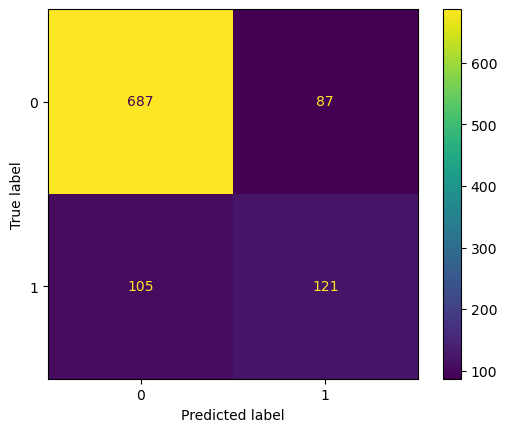

In [11]:
################################
# Task 2: Ensemble Models for Income Prediction
################################

print("Task 2: Ensemble Models for Income Prediction")

# Import the data
income_df = pd.read_csv("HW9_income.csv")
print(f"Income data shape: {income_df.shape}")

# Create HighIncome variable (1 if Salary is >50K, 0 otherwise)
income_df['HighIncome'] = income_df['Salary'].map(lambda x: 1 if '>50K' in x else 0)
print("HighIncome distribution:")
income_df['HighIncome'].value_counts(normalize=True)

# Drop the original Salary column
income_df.drop('Salary', axis=1, inplace=True)

# Feature selection and preparation
# 1) Encode categorical features
cat_features = ['Workclass', 'Education', 'MaritalStatus', 'Occupation', 
                'Relationship', 'Race', 'Sex', 'NativeCountry']

for feature in cat_features:
    income_df[f'{feature}_code'] = LabelEncoder().fit_transform(income_df[feature])

# Look at correlations with target variable
numeric_income = income_df.select_dtypes(include=[np.number])
corr_income = numeric_income.corr()['HighIncome'].abs().sort_values(ascending=False)
print("\nFeature correlations with HighIncome:")
print(corr_income.head(10))  # Top 10 correlations

# Select features with correlation above threshold
threshold = 0.1  # Features with correlation > 0.1
selected_features = list(corr_income[corr_income > threshold].index)
selected_features.remove('HighIncome')  # Remove target from feature list
print(f"\nSelected features (correlation > {threshold}):")
print(selected_features)

# Drop original categorical columns - keeping only encoded versions
income_df = income_df.drop(cat_features, axis=1)

# Prepare data for modeling
X_income = income_df[selected_features]
y_income = income_df['HighIncome']

# Split data for modeling (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_income, y_income, test_size=0.25, random_state=101
)

print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")

################################
# Task 2.a: Decision Tree Model
################################

print("\nTask 2.a: Decision Tree Model")
dt_model = DecisionTreeClassifier(random_state=101)
dt_model.fit(X_train, y_train)

# Predictions
dt_preds = dt_model.predict(X_test)

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(dt_model, X_test, y_test)

# Evaluation metrics
dt_accuracy = accuracy_score(y_test, dt_preds)
print(f"Decision Tree Accuracy Score = {dt_accuracy:.4f}")
print("Decision Tree Classification Report:")
print(classification_report(y_test, dt_preds))

# Feature importance
dt_importances = pd.Series(dt_model.feature_importances_, index=X_train.columns)
print("\nDecision Tree Feature Importance:")
print(dt_importances.sort_values(ascending=False).head(5))

## Task 2.b: Random Forest Model


Task 2.b: Random Forest Model


<Figure size 800x600 with 0 Axes>

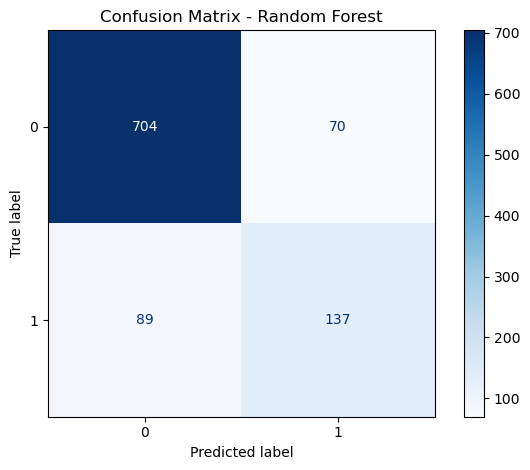

RF Accuracy Score = 0.8410
RF Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       774
           1       0.66      0.61      0.63       226

    accuracy                           0.84      1000
   macro avg       0.77      0.76      0.77      1000
weighted avg       0.84      0.84      0.84      1000



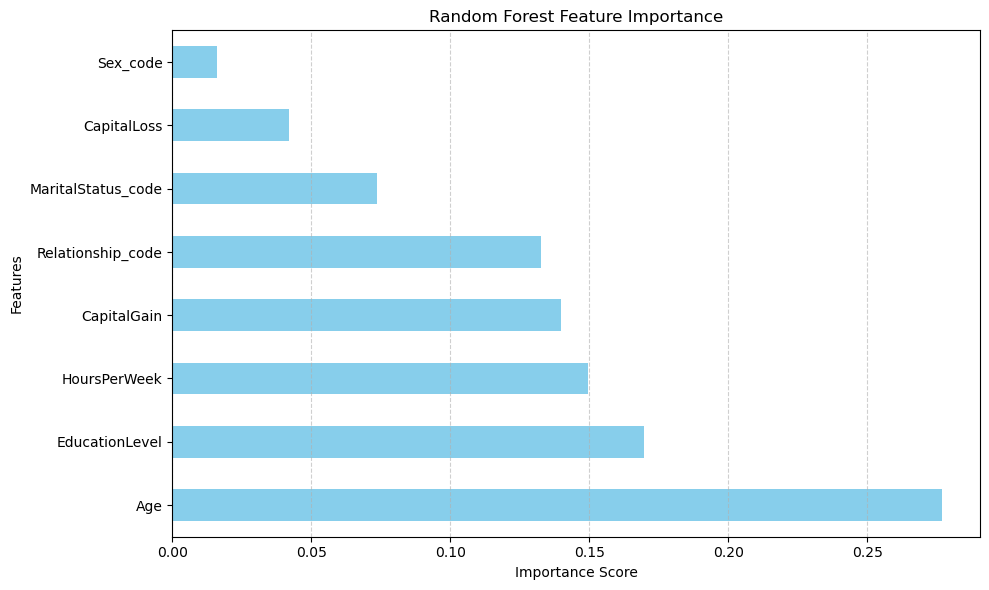

Top 5 most important features:
Age                  0.276655
EducationLevel       0.169824
HoursPerWeek         0.149454
CapitalGain          0.139922
Relationship_code    0.132516
dtype: float64


In [13]:
################################
# Task 2.b: Random Forest Model
################################

print("\nTask 2.b: Random Forest Model")

# Train Random Forest model
rfc = RandomForestClassifier(random_state=101, n_estimators=100, max_features="sqrt")
rfc.fit(X_train, y_train)

# Confusion matrix:
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(rfc, X_test, y_test, cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.tight_layout()
plt.savefig('rf_confusion_matrix.png')
plt.show()

# Evaluation metrics:
y_pred = rfc.predict(X_test)
rfc_score = accuracy_score(y_test, y_pred)
print(f'RF Accuracy Score = {rfc_score:.4f}')
print('RF Classification Report:')
print(classification_report(y_test, y_pred))

# Feature importance - creating a separate, clear visualization
plt.figure(figsize=(10, 6))
feat_imp = pd.Series(rfc.feature_importances_, index=X_train.columns)
feat_imp.sort_values(ascending=False).head(10).plot(kind='barh', color='skyblue')
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
plt.show()
print("Top 5 most important features:")
print(feat_imp.sort_values(ascending=False).head(5))

## Task 2.c: Gradient Boosting Model


Task 2.c: Gradient Boosting Model


<Figure size 800x600 with 0 Axes>

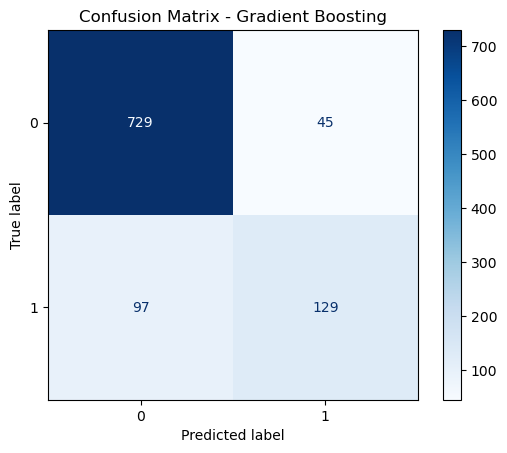

GB Accuracy Score = 0.8580
GB Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       774
           1       0.74      0.57      0.65       226

    accuracy                           0.86      1000
   macro avg       0.81      0.76      0.78      1000
weighted avg       0.85      0.86      0.85      1000



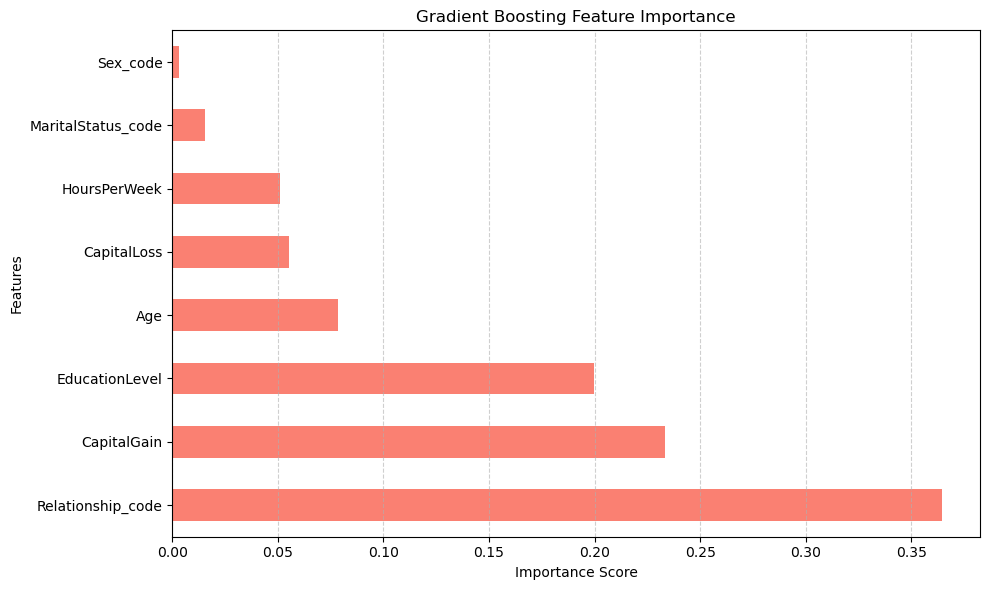

Top 5 most important features:
Relationship_code    0.364231
CapitalGain          0.233062
EducationLevel       0.199659
Age                  0.078312
CapitalLoss          0.055296
dtype: float64


In [35]:
################################
# Task 2.c: Gradient Boosting Model
################################

print("\nTask 2.c: Gradient Boosting Model")

# Train Gradient Boosting model
gbc = GradientBoostingClassifier(random_state=101, n_estimators=100, learning_rate=0.1)
gbc.fit(X_train, y_train)

# Confusion matrix (as a separate figure)
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(gbc, X_test, y_test, cmap='Blues')
plt.title('Confusion Matrix - Gradient Boosting')
plt.savefig('gb_confusion_matrix.png')
plt.show()

# Evaluation metrics
y_pred = gbc.predict(X_test)
gbc_score = accuracy_score(y_test, y_pred)
print(f'GB Accuracy Score = {gbc_score:.4f}')
print('GB Classification Report:')
print(classification_report(y_test, y_pred))

# Feature importance (as a separate figure with horizontal bars)
plt.figure(figsize=(10, 6))
feat_imp = pd.Series(gbc.feature_importances_, index=X_train.columns)
feat_imp.sort_values(ascending=False).head(10).plot(kind='barh', color='salmon')
plt.title('Gradient Boosting Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('gb_feature_importance.png')
plt.show()

print("Top 5 most important features:")
print(feat_imp.sort_values(ascending=False).head(5))

### d. Compare the performance of the Decision Tree model with each of the ensemble 
### models. Can you explain the differences based on each model’s objectives

In [45]:
import pandas as pd
from IPython.display import display

# Create performance comparison table
table = {
    'Model': ['Decision Tree', 'Random Forest', 'Gradient Boosting'],
    'Accuracy': [0.8080, 0.8410, 0.8580],
    'Precision (Class 1)': [0.58, 0.66, 0.74],
    'Recall (Class 1)': [0.54, 0.61, 0.57],
    'F1-Score (Class 1)': [0.56, 0.63, 0.65]
}

# Create DataFrame and display
performance_df = pd.DataFrame(table)
display(performance_df)

,Model,Accuracy,Precision (Class 1),Recall (Class 1),F1-Score (Class 1)
0,Decision Tree,0.808,0.58,0.54,0.56
1,Random Forest,0.841,0.66,0.61,0.63
2,Gradient Boosting,0.858,0.74,0.57,0.65


### The comparison of Decision Tree, Random Forest, and Gradient Boosting models for income prediction reveals significant performance differences. The Decision Tree model achieved an accuracy of 0.8080, with 0.58 precision and 0.54 recall for predicting high-income individuals. While this performance is reasonable, it falls short compared to the ensemble methods.
### Random Forest substantially improved upon the Decision Tree's performance, reaching 0.8410 accuracy with better metrics for the high-income class (0.66 precision, 0.61 recall, and 0.63 F1-score). This enhancement stems from Random Forest's fundamental approach of combining multiple decision trees trained on random subsets of data and features. By aggregating the predictions of many trees through voting, Random Forest effectively reduces overfitting and produces more stable predictions than a single tree.
### Gradient Boosting demonstrated the strongest performance overall with 0.8580 accuracy and notably higher precision (0.74) for high-income predictions. Unlike Random Forest, which builds trees independently, Gradient Boosting constructs trees sequentially, with each new tree specifically designed to correct the errors made by the previous ensemble. This adaptive focus on difficult examples allows Gradient Boosting to address the shortcomings of earlier trees and continuously improve prediction accuracy.
### The superior performance of ensemble methods can be attributed to their fundamental objectives of reducing either variance (Random Forest) or bias (Gradient Boosting). Decision Trees alone tend to create rigid decision boundaries that can overfit training data and struggle with complex relationships. Random Forest mitigates this problem through its bootstrap aggregation approach, while Gradient Boosting tackles it through its iterative error correction mechanism. These complementary strategies allow ensemble methods to create more flexible decision boundaries that better capture the underlying patterns in the data, particularly for challenging classification cases like identifying high-income individuals.